# Optimization

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 

**Context:** We can use `NumPyro` to perform the MLE on a class of models, composed of discrete distributions. The MLE involves solving an optimization problem---finding the parameters that maximize the joint data likelihood. So far, we've let `NumPyro` take care of this optimization problem for us. But what is `NumPyro` doing under the hood? 

**Outline:**
* Introduce (exact) analytical optimization, which rely on person to do most of the work via pen-and-paper math.
* Introduce (approximate) numerical optimization, which rely on the machine to do the work for us, like `NumPyro`.
* Discuss tradeoffs between the two.

## Analytic Solutions to Optimization Problems

**Goal:** Recall that our goal is to maximize the joint data log-likelihood:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_\theta \text{ } p(\mathcal{D}; \theta),
\end{align}
where $\theta$ represents our model parameters. We will remain consistent with the convention of ML literature; we re-write the above problem as a minimization problem of our *negative* log-likelihood. 
\begin{align}
\theta^\text{MLE} &= \mathrm{argmin}_\theta \underbrace{-p(\mathcal{D}; \theta)}_{\text{Our loss function, } \mathcal{L}(\theta)}
\end{align}
We call the $\mathcal{L}(\theta)$ our "loss function," since our goal is now to minimize our losses.

**Intuition:** So how can we identify the minima of $\mathcal{L}(\theta)$? A good place to start is to determine what makes $\mathcal{L}(\theta)$ different at its minima. Let's see if we can get some intuition by looking at some intuition by looking at loss functions we made up.

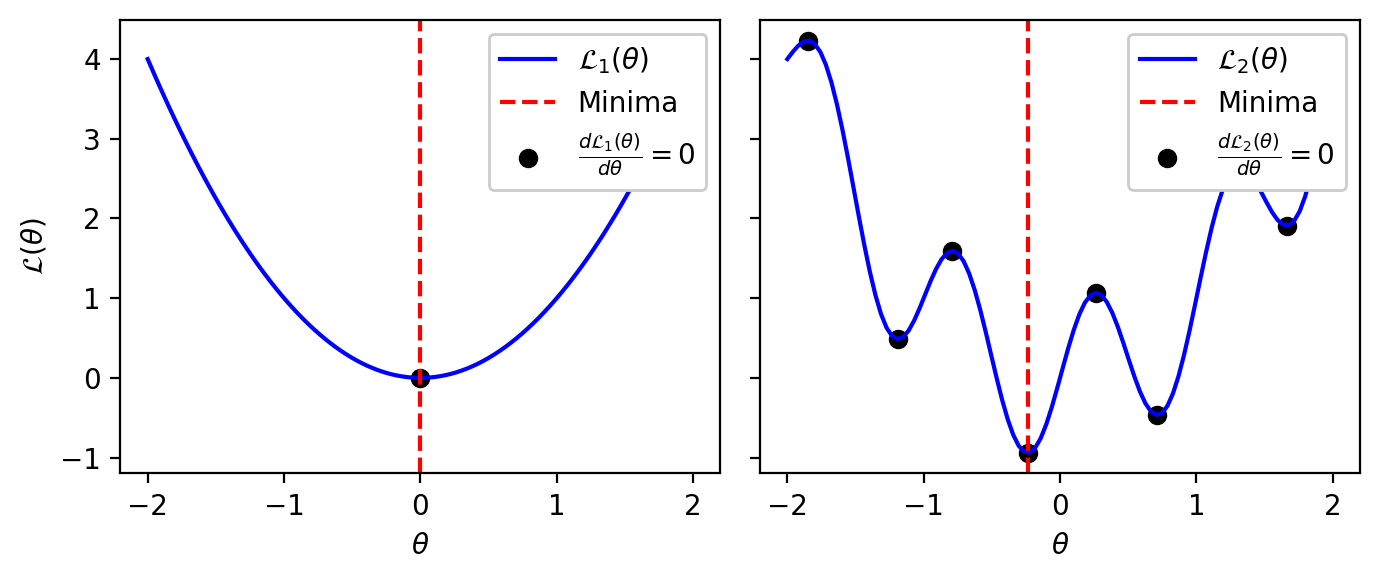

In [2]:
plot_example_loss_functions()

Looking at the left plot above, we see that the minimum has a unique property: the loss function is *flat at the minimum*. In other words, at the minimum, the derivative of the loss function equals zero: 
\begin{align}
\frac{d \mathcal{L}(\theta)}{d \theta} = 0
\end{align}
Does the same hold for the right plot? Not exactly... At the minimum, we do have $\frac{d \mathcal{L}(\theta)}{d \theta} = 0$. But there are other points for which we also have $\frac{d \mathcal{L}(\theta)}{d \theta} = 0$. 

Nonetheless, for these two functions, it seems that looking at the points for which the loss is flat is helpful. Instead of looking at every possible value of $\theta$ (in these plots, $\theta$ can take on infinite different values), we just need to examine the points for which the loss is flat. For the plot on the left, this strategy directly found the minimum. For the plot on the right, this strategy found a small set of points that *includes* the minimum. To find the minimum within this set, all we need to do is evaluate the loss at each point and select the one that yields the smallest loss.

**Procedure:** We can turn this intuition into the following four-step process.
1. Compute the derivative of the loss function: $\frac{d \mathcal{L}(\theta)}{d \theta}$
2. Set the derivative of the loss function equal to $0$: $\frac{d \mathcal{L}(\theta)}{d \theta} = 0$
3. Solve the equation for *all possible values* of $\theta$ analytically (i.e. on pen-and-paper)---this is the difficult part!
4. Plug each possible value of $\theta$ into our loss function $\mathcal{L}(\theta)$ and select the one(s) that minimize it.

## An Example: Analytically Solving for the MLE

**The Model.** Let's see how this works by analytically performing the MLE on a simple example. Suppose we want to model the probability of a patient being hospitalized overnight. We can do this using a Bernoulli distribution:
\begin{align}
H \sim p_H(\cdot; \rho) = \mathrm{Bern}(\rho).
\end{align}
Recall that the PMF of a Bernoulli RV is,
\begin{align}
p_H(h; \rho) = \rho^{\mathbb{I}(h = 1)} \cdot (1 - \rho)^{\mathbb{I}(h = 0)},
\end{align}
where $\mathbb{I}(\cdot)$ is an *indicator variable*---it evaluates to 1 if the condition in parentheses is true and 0 otherwise. 

**The Joint Data Likelihood.** Now, let's write the joint data log-likelihood for our model:
\begin{align}
\log p(\mathcal{D}; \rho) &= \log \prod\limits_{n=1}^N p(\mathcal{D}_n; \rho) \quad (\text{since observations are i.i.d}) \\
&= \log \prod\limits_{n=1}^N p_H(h_n; \rho) \\
&= \log \prod\limits_{n=1}^N \rho^{\mathbb{I}(h_n = 1)} \cdot (1 - \rho)^{\mathbb{I}(h_n = 0)} \quad (\text{using the definition of Bernoulli PMF}) \\
&= \sum\limits_{n=1}^N \log \rho^{\mathbb{I}(h_n = 1)} + \log (1 - \rho)^{\mathbb{I}(h_n = 0)} \quad (\text{using the fact that } \log (x \cdot y) = \log x + \log y) \\
&= \sum\limits_{n=1}^N \mathbb{I}(h_n = 1) \cdot \log \rho + \mathbb{I}(h_n = 0) \cdot \log (1 - \rho) \quad (\text{using the fact that } \log x^y = y \cdot \log x)  \\
&= \underbrace{\left( \sum\limits_{n=1}^N \mathbb{I}(h_n = 1) \right)}_{\text{Total number of times $H = 1$}} \cdot \log \rho + \underbrace{\left( \sum\limits_{n=1}^N \mathbb{I}(h_n = 0) \right)}_{\text{Total number of times $H = 0$}} \cdot \log (1 - \rho) \quad (\text{moving terms that do not depend on the sums out}) \\
&= T \cdot \log \rho + (N - T) \cdot \log (1 - \rho)
\end{align}
where $T = \sum\limits_{n=1}^N \mathbb{I}(h_n = 1)$ is the total number of hospitalizations.

**The MLE Objective.** Our MLE objective is therefore:
\begin{align}
\rho^\text{MLE} &= \mathrm{argmax}_{\rho} \text{ } \log p(\mathcal{D}; \rho) \\
&= \mathrm{argmax}_{\rho} \left( T \cdot \log \rho - (N - T) \cdot \log (1 - \rho) \right) \\
&= \mathrm{argmin}_{\rho} \underbrace{\left( -T \cdot \log \rho + (N - T) \cdot \log (1 - \rho) \right)}_{\text{Our loss function: } \mathcal{L}(\rho)} \quad (\text{maximizing a function is equivalent to minimizing its negative})
\end{align}

**Analytic Optimization.** We take the gradient of the above loss $\mathcal{L}(\rho)$ with respect to $\rho$, set it to $0$ and solve:
\begin{align}
0 &= \frac{d \mathcal{L}(\rho)}{d \rho} \\
&= -\frac{T}{\rho} + \frac{N - T}{1 - \rho} \quad (\text{taking the derivative of } \mathcal{L}(\rho)) \\
&= \frac{T - N \cdot \rho}{\rho \cdot (\rho - 1)} \quad (\text{bringing fractions under common denominator}) \\
&= T - N \cdot \rho \quad (\text{multiplying both sides by } \rho \cdot (\rho - 1))
\end{align}
Solving the above gives us the solution,
\begin{align}
\rho &= \frac{T}{N}.
\end{align}
The solution is exactly the proportion of hospitalizations out of the total number of hospital visits!

**A Note on Constraint Optimization.** Oftentimes, when performing the MLE analytically, we need to constrain the parameters to lie within valid ranges. For example, $\rho$ should only be allowed to take on values between $0$ and $1$. Formally, we express such a constraint as follows:
\begin{align}
\rho^\text{MLE} &= \mathrm{argmax}_{\rho} \text{ } \log p(\mathcal{D}; \rho) \quad \text{subject to} \quad 0 \leq \rho \leq 1 \\
\end{align}
In our derivation, it just so happens that the solution already satisfies this constraint. However, for different models, we may have to enforce such constraints explicitly. To enforce these constraints, one can use [lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier). We will not cover this method in here, but just want to point out that this class of methods exists.

## Challenges with Analytic Solutions to Optimization Problems

As you can see from the above example, performing optimization analytically suffers from two challenges:
1. **Analytic optimization needs a specialized solution for every model.** As you can see from the above example, performing the optimization analytically will require a new derivation for each model. However, when working with real data, we rarely know what's the "right" model a priori. We typically start with an exploratory data analysis, try different models, evaluate them using different metrics, make hypotheses for why the models don't fit well, revise the models to fit better, and repeat. If we had to derive a new solution for every model we wish to test, our modeling process will become quite cumbersome. Moreover, we are more prone to make errors in the derivation and write bugs in our code. 
2. **Analytic optimization cannot solve for the parameters of every model.** Since the above example is for a simple Bernoulli model, an analytic solution to the MLE exists. However, for more complex problems, that may not be the case. In fact, for modern ML models, it is *rare* for there to exist an analytic solution.

This motivates us to look into alternative optimization methods: numeric optimization.

## Numeric Solutions to Optimization Problems

Numeric optimizations algorithms address both shortcomings of analytic optimization:
1. They can be easily applied to different models without cumbersome derivations. This is because they can be conveniently implemented behind abstractions. Moreover, these abstractions allow us to pair different numeric optimization algorithms with different models *without having to write much code*. They even make it easy to incorporate constraints over the parameters into the optimization. This helps us write bug-free, error-free optimization code.
2. They can be applied to optimization problems for which there exists no analytic optimization solution. They are also fast and work well in practice, making them extremely popular for complicated modern ML models.

Of course, these numerical algorithms have their own challenges---we'll look into some challenges they face in a bit. Let us introduce the simplest and most popular numerical optimization algorithm: *gradient descent*.

**Gradient Descent.** The gradient (or "multivariate derivative") is the direction of the steepest ascent. Similarly, the negative gradient is the direction of the steepest descent. The idea behind the *gradient descent* algorithm is to take little steps in the direction of the negative gradient in hope that, after taking enough steps, we'll reach the minimum. Let's illustrate this with an animation:

<center>
    <p>
        <img src="https://miro.medium.com/v2/resize:fit:875/1*vchQOUUW_RPVjkb4pQF-1A.gif" width="500px" />
    </p>
    <p>
        <small>GIF from <a href="https://towardsai.net/p/machine-learning/deep-learning-from-scratch-in-modern-c-gradient-descent">Deep Learning from Scratch in Modern C++: Gradient Descent</a></small>
    </p>
</center>

In the animation, the vertical axis represents $\mathcal{L}(\theta)$. The two horizontal axes represent the dimensions of $\theta$ (in this case, it's 2-dimensional). Each arrow represents the negative gradient. As you can see, in each iteration of the algorithm, $\theta$ (the red point) moves in the direction of the gradient, progressively minimizing the loss.

**Algorithm.** Now, let's write the gradient descent algorithm:

* **Step 1.** Select an initial value for the model parameters: $\theta^\text{current} \leftarrow \text{initial value}$.

* **Step 2.** Repeat until the loss doesn't change much from iteration to iteration:
  * **Step 2a.** Compute the gradient of the loss with respect to the parameters, evaluated at the current value of the parameters:
\begin{align}
u &\leftarrow \frac{d \mathcal{L}(\theta)}{d \theta} \Bigg|_{\theta = \theta^\text{current}}
\end{align}
  * **Step 2b.** Take a step in the direction of the negative gradient (steepest descent):
\begin{align}
\theta^\text{next} &\leftarrow \theta^\text{current} - \alpha \cdot u
\end{align}
  * **Step 2c.** Update the model parameters:
\begin{align}
\theta^\text{current} &\leftarrow \theta^\text{next}
\end{align}

In this algorithm, notice that there's one variable we have yet to define: $\alpha$. Here, $\alpha$ represents the size of the step we plan to take in the direction of the gradient. It is typically called the *learning rate*. You will have to play with this parameter to determine what value works best for minimizing your loss. According to ML wizardry lore, a good place to start is with $\alpha = 0.01$. 

## Challenges with Numeric Optimization

**Local optima.**

**Hyper-parameters.**